In [ ]:
# Download dataset
!pip install -q gdown

# plant_leave_diseases_train.zip
!gdown https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0

# plant_leave_diseases_test.zip
!gdown https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8

Downloading...
From (original): https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0
From (redirected): https://drive.google.com/uc?id=1MCQ2ldiKZUeVM1rVw1gPlBaX43AJB3R0&confirm=t&uuid=781c5d4a-c545-40c4-bf85-3e63a3f8b5a5
To: /content/plant_leave_diseases_train.zip
100% 682M/682M [00:15<00:00, 44.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8
From (redirected): https://drive.google.com/uc?id=1yqvfEVeb0IAutxZK83_wUoUWm5apYSF8&confirm=t&uuid=52b9b2b3-9269-4761-849c-ccc1102bb9fb
To: /content/plant_leave_diseases_test.zip
100% 170M/170M [00:00<00:00, 175MB/s]


In [ ]:
import zipfile

# Unzip data
with zipfile.ZipFile('plant_leave_diseases_train.zip', 'r') as zip_file:
    zip_file.extractall()

with zipfile.ZipFile('plant_leave_diseases_test.zip', 'r') as zip_file:
    zip_file.extractall()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Paths to your folders
train_data_dir = 'plant_leave_diseases_train'

# Image settings
img_size = (256, 256)
batch_size = 32

# Create a ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data generator
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 34756 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained MobileNetV2
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze for fine-tuning

# Optionally freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-4-2036352037.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

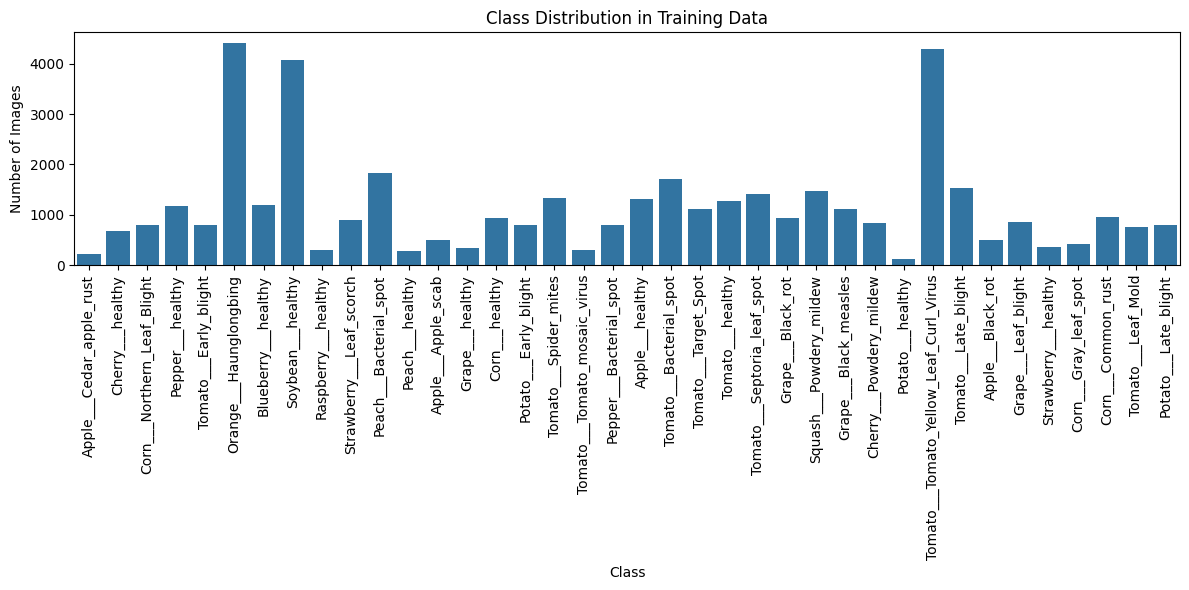

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count images per class
class_counts = {}
for class_name in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


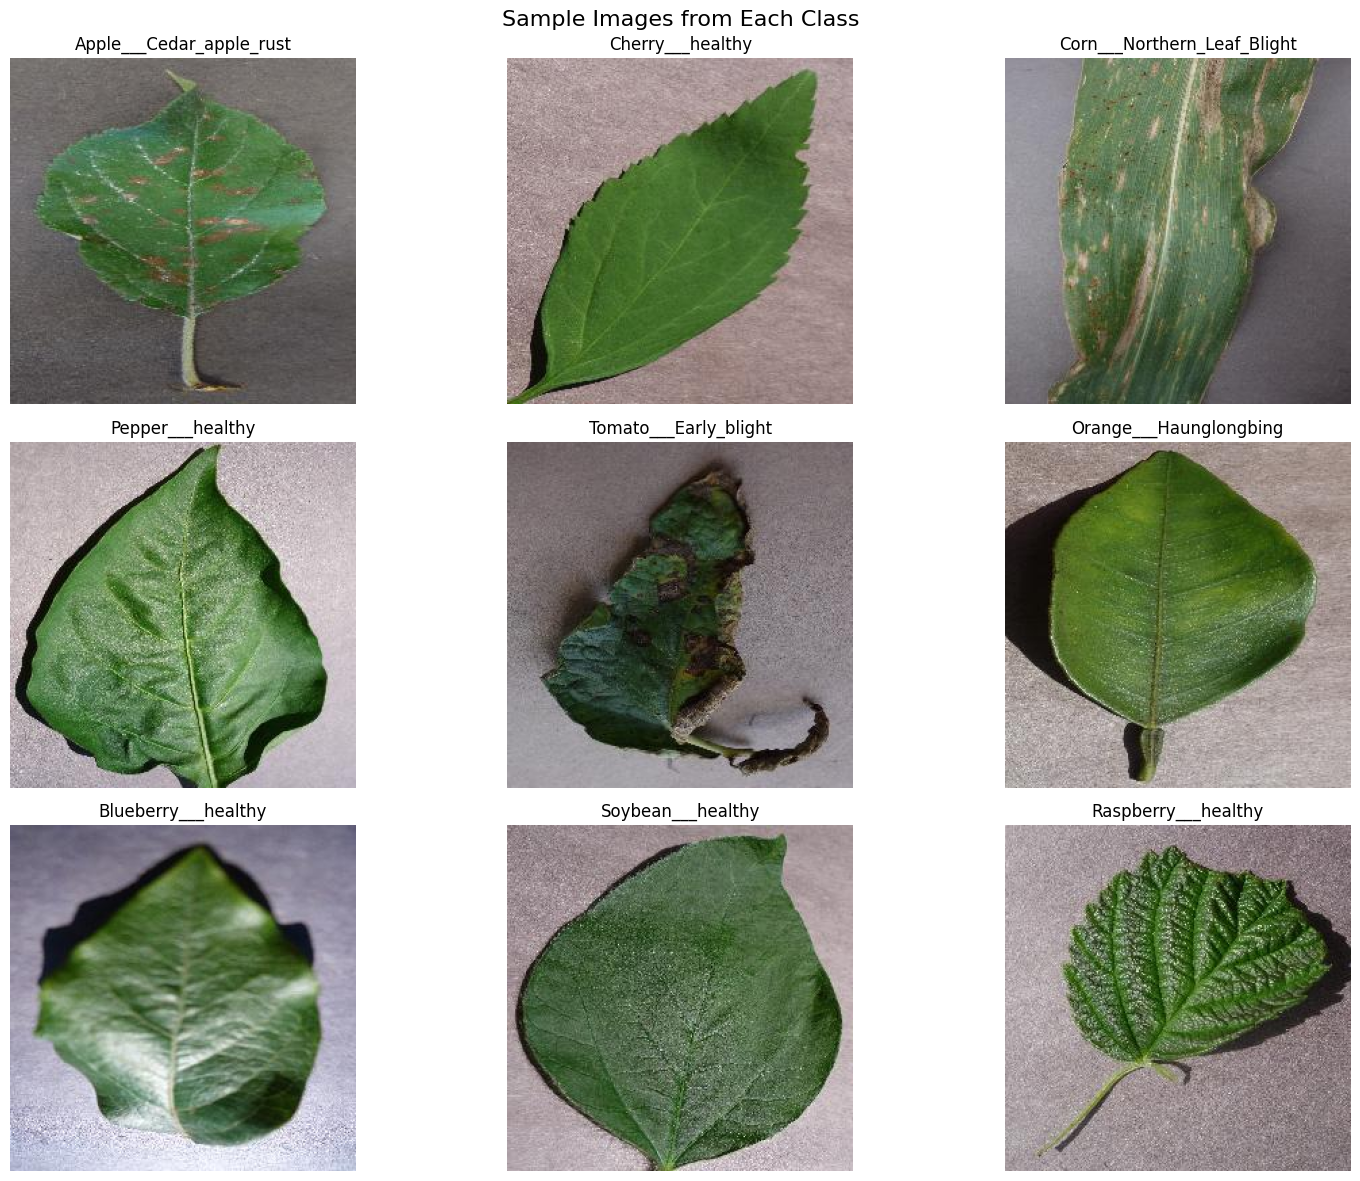

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show one image per class
plt.figure(figsize=(16, 12))
for i, class_name in enumerate(list(class_counts.keys())[:9]):
    img_path = os.path.join(train_data_dir, class_name, os.listdir(os.path.join(train_data_dir, class_name))[0])
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


Train the **Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 699s 620ms/step - accuracy: 0.7646 - loss: 0.8995 - val_accuracy: 0.8705 - val_loss: 0.4616 - learning_rate: 1.0000e-04
Epoch 2/5
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 675s 621ms/step - accuracy: 0.9690 - loss: 0.0979 - val_accuracy: 0.9626 - val_loss: 0.1129 - learning_rate: 1.0000e-04
Epoch 3/5
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 653s 601ms/step - accuracy: 0.9817 - loss: 0.0584 - val_accuracy: 0.9769 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 4/5
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 668s 614ms/step - accuracy: 0.9866 - loss: 0.0432 - val_accuracy: 0.9773 - val_loss: 0.0651 - learning_rate: 1.0000e-04
Epoch 5/5
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 653s 601ms/step - accuracy: 0.9896 - loss: 0.0327 - val_accuracy: 0.9797 - val_loss: 0.0608 - learning_rate: 1.0000e-04


In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

test_dir = 'plant_leave_diseases_test'
test_images = sorted(os.listdir(test_dir))

# Get class index to label mapping
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

results = []

for img_name in test_images:
    img_id = img_name.split('.')[0]
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = idx_to_class[np.argmax(prediction)]
    results.append([img_id, predicted_class])


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

In [ ]:
submission_df = pd.DataFrame(results, columns=["id", "class"])
submission_df = submission_df.sort_values(by='id')  # optional
submission_df.to_csv("submission_12503989_TeamOne.csv", index=False, encoding='utf-8')


272/272 ━━━━━━━━━━━━━━━━━━━━ 131s 470ms/step


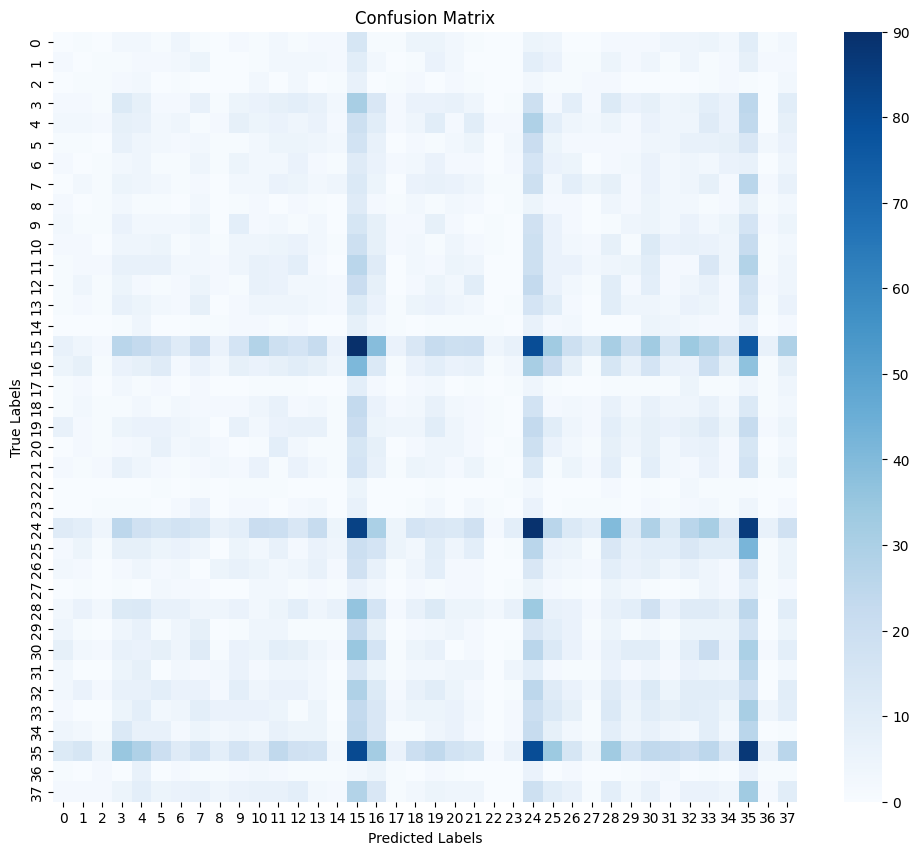

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation data
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))


Classification Report:
                                        precision    recall  f1-score   support

                    Apple___Apple_scab       0.00      0.00      0.00       100
                     Apple___Black_rot       0.00      0.00      0.00        99
              Apple___Cedar_apple_rust       0.02      0.02      0.02        44
                       Apple___healthy       0.05      0.05      0.05       263
                   Blueberry___healthy       0.03      0.03      0.03       240
               Cherry___Powdery_mildew       0.02      0.02      0.02       168
                      Cherry___healthy       0.01      0.01      0.01       136
                    Corn___Common_rust       0.01      0.01      0.01       190
                 Corn___Gray_leaf_spot       0.00      0.00      0.00        82
           Corn___Northern_Leaf_Blight       0.05      0.06      0.06       157
                        Corn___healthy       0.02      0.02      0.02       185
                